# MY WAY

Please note that our team had several beginners so here we approached to the problem with aim to learn how to train your own network and learn useful tricks on the way. Therefore we start all the way from linear model :).

Cleaned notebook with only the final model will follow shortly.

I always make a sample to test and prototype things, and when I am happy I let the model looks at the whole dataset. I like babysitting my models to make them both fast and accurate. This way I can build faster and more accurate models compared to standard pipelines with from tutorials :)

In [30]:
from keras.preprocessing import image
from keras.models import Model, Input, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Lambda, Flatten, Conv2D, MaxPool2D, AvgPool2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, rmsprop
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras import metrics

%matplotlib inline

In [109]:
def report(validation_generator):    
    Y_true = get_labels(validation_generator)
    Y_pred = model.predict_generator(validation_generator, nb_validation_samples/batch_size+1)
    
    Y_true = np.argmax(Y_true, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)
    #print Y_true[:10]
    cm = confusion_matrix(Y_true, Y_pred, labels=None)
    cr = classification_report(Y_true, Y_pred, labels=None)
    print cm
    print cr
    plot_conf_mat(Y_true, Y_pred, labels=classes)
    
    return cm, cr

In [227]:
def plot_classification_report(validation_generator,labels=False, figsize=(10, 20), ax=None):
    
    Y_true = get_labels(validation_generator)
    Y_pred = model.predict_generator(validation_generator, nb_validation_samples/batch_size+1)
    
    Y_true = np.argmax(Y_true, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)
    
    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score']


    
    cr = precision_recall_fscore_support(Y_true, Y_pred)
    a =  cr[-1]
    yticks = [labels[i][:3]+"-"+labels[i].split()[-1]+",  "+str(a[i]) for i in range(len(labels))]
    yticks += ['avg']
    
    rep = np.array(cr).T
    avg = precision_recall_fscore_support(Y_true, Y_pred, average = "weighted")
#     avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sn.heatmap(rep[:,:-1],
                annot=True, 
                cmap="BuGn", 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)
    
    plt.title('Classification report', fontsize=32)

    plt.ylabel('Classes, N images in validation')
    plt.savefig("./class_rep.eps")
    plt.savefig("./class_rep.svg")

In [235]:
def plot_conf_mat(Y_true, Y_pred, labels=True):
    if not labels:
        labels = np.unique(Y_true, return_counts=True)[0]
    array = confusion_matrix(Y_true, Y_pred)
    C = array / array.astype(np.float).sum(axis=1)[:, np.newaxis]
    a = [] 
    for i in C:
        a.append([round(e,2) for e in i])

    df_cm = pd.DataFrame(a)
    plt.figure(figsize = (40,28))
    df_cm = pd.DataFrame(a, range(len(labels)),
                      range(len(labels)))
    #plt.figure(figsize = (10,7))
    a = np.unique(Y_true, return_counts=True)[1]
    ylabels = [labels[i][:3]+"-"+labels[i].split()[-1]+", "+str(a[i]) for i in range(len(labels))]
    sn.set(font_scale=1.)#for label size
    sn.heatmap(df_cm,  annot=True, annot_kws={"size": 16}, linewidth=0,xticklabels=labels, yticklabels=ylabels, cmap="YlGnBu")
    plt.title('Confusion matrix - Top1 suggestion', fontsize=32)
    plt.yticks(rotation=0, ha="right", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=16)
#     plt.set_xticklabels( )
    plt.ylabel('True, N')
    plt.xlabel('Predicted')
    plt.savefig("./conf.eps")
    plt.savefig("./conf.svg")

In [4]:
def get_class_labels(train_generator):
    return sorted(train_generator.class_indices)

def get_labels(generator):
    return np.concatenate([generator.next()[1] for i in range(0, generator.samples, batch_size)])

def train_few_epochs(model, num_epochs, verbose=1):
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=num_epochs,
        verbose=verbose,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
    return model

def norm_input(x):
    return (x-mean_px)/std_px

def calculate_mean_std(train_generator):
    model = Sequential([
        Lambda(f, input_shape=(img_width, img_height,3))])

    steps = nb_train_samples/batch_size+1
    X = model.predict_generator(train_generator,steps)
    mean_px = X.mean()
    std_px = X.std()
    return (mean_px, std_px)

def f(x):
    return x

In [5]:
home = "/media/miroslav/Seagate Expansion Drive/DL_projects/kaufland/"

In [8]:
img_width, img_height = 128, 128

train_dir = home + 'data/train/'
valid_dir = home + 'data/valid/'
# test_dir  = home + 'data/test/'

nb_train_samples = 33991
nb_validation_samples = 3804
nb_test_samples = 228

num_classes = 68
epochs = 1
batch_size = 512

In [7]:
img_width, img_height = 224, 224

train_dir = home + 'data/sample/train/'
valid_dir = home + 'data/sample/valid/'

# test_dir  = './datathon_dataset/sample/test/'

nb_train_samples = 671
nb_validation_samples = 340
# nb_test_samples = 228

num_classes = 68
epochs = 1
batch_size = 128

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
#         width_shift_range=0.02,
#         height_shift_range=0.02,
#         shear_range=0.01,
#         zoom_range=0.02,    
#         rotation_range=5,
#         horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        )




validation_datagen = ImageDataGenerator(
         rescale=1./255,
#         width_shift_range=0.02,
#         height_shift_range=0.02,
#         shear_range=0.01,
#         zoom_range=0.02,
    
#         rotation_range=10,
#         horizontal_flip=True,
)
validation_generator = validation_datagen.flow_from_directory(
        valid_dir,
        shuffle = False,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        )



# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         )

Found 33991 images belonging to 68 classes.
Found 3804 images belonging to 68 classes.


In [10]:
# (mean_px, std_px) = calculate_mean_std(train_generator)

KeyboardInterrupt: 

In [11]:
classes = get_class_labels(train_generator)

# EVERYTHING WITH SAMPLE SET
## Linear model

I always start with linear model. Here you proof that the model will learn. Note it is already better than VGG16 as expected

In [11]:
def get_lin_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(img_width, img_height, 3)),
#         BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Flatten(),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model = get_lin_model()
model.optimizer.lr=0.0001
model = train_few_epochs(model, 12)
model.optimizer.lr=0.001
model = train_few_epochs(model, 10)

#report()

Epoch 1/12
5/5 [==============================] - 4s - loss: 6.4225 - acc: 0.0951 - val_loss: 8.4709 - val_acc: 0.1211
Epoch 2/12
5/5 [==============================] - 2s - loss: 5.3704 - acc: 0.3000 - val_loss: 7.9939 - val_acc: 0.1172
Epoch 3/12
5/5 [==============================] - 2s - loss: 3.8572 - acc: 0.4281 - val_loss: 6.9931 - val_acc: 0.1289
Epoch 4/12
5/5 [==============================] - 2s - loss: 2.4047 - acc: 0.5768 - val_loss: 7.2513 - val_acc: 0.1328
Epoch 5/12
5/5 [==============================] - 2s - loss: 1.9713 - acc: 0.6534 - val_loss: 7.6091 - val_acc: 0.1211
Epoch 6/12
5/5 [==============================] - 2s - loss: 1.6322 - acc: 0.7259 - val_loss: 7.0597 - val_acc: 0.1562
Epoch 7/12
5/5 [==============================] - 2s - loss: 1.0488 - acc: 0.8163 - val_loss: 6.9861 - val_acc: 0.1484
Epoch 8/12
5/5 [==============================] - 2s - loss: 0.8366 - acc: 0.8325 - val_loss: 7.1519 - val_acc: 0.1406
Epoch 9/12
5/5 [==============================] 

## Linear model + Dropout
Then I add a Droput (discurd data at random to avoid overfitting). It helps a lot (see how loss is lowered)

In [17]:
def get_lin_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(img_width, img_height, 3)),
#         BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Flatten(),
        Dropout(0.8),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = get_lin_model()
model.optimizer.lr=0.0001
model = train_few_epochs(model, 2)
model.optimizer.lr=0.001
model = train_few_epochs(model, 10)


Epoch 1/2
5/5 [==============================] - 3s - loss: 8.0109 - acc: 0.0467 - val_loss: 5.5622 - val_acc: 0.0859
Epoch 2/2
5/5 [==============================] - 2s - loss: 7.0497 - acc: 0.0756 - val_loss: 5.4368 - val_acc: 0.0703
Epoch 1/10
5/5 [==============================] - 3s - loss: 4.9820 - acc: 0.2007 - val_loss: 5.3025 - val_acc: 0.1211
Epoch 2/10
5/5 [==============================] - 2s - loss: 4.1546 - acc: 0.3102 - val_loss: 5.1493 - val_acc: 0.1523
Epoch 3/10
5/5 [==============================] - 2s - loss: 3.3265 - acc: 0.3748 - val_loss: 5.1823 - val_acc: 0.1406
Epoch 4/10
5/5 [==============================] - 2s - loss: 2.9518 - acc: 0.4280 - val_loss: 4.9198 - val_acc: 0.1875
Epoch 5/10
5/5 [==============================] - 2s - loss: 2.5481 - acc: 0.4787 - val_loss: 5.0696 - val_acc: 0.1484
Epoch 6/10
5/5 [==============================] - 2s - loss: 1.9723 - acc: 0.5469 - val_loss: 5.0635 - val_acc: 0.1758
Epoch 7/10
5/5 [==============================] - 

In [ ]:
report()

## Single dense layer
it will learn but it will take longer time to converge

In [19]:
def get_fc_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(img_width, img_height, 3)),
#         BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Flatten(),
        Dense(512),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = get_fc_model()
model.optimizer.lr=0.0001
model = train_few_epochs(model, 2)
model.optimizer.lr=0.01
model = train_few_epochs(model, 10)
# report()

Epoch 1/2
5/5 [==============================] - 4s - loss: 12.7851 - acc: 0.0507 - val_loss: 15.0858 - val_acc: 0.0469
Epoch 2/2
5/5 [==============================] - 2s - loss: 14.0306 - acc: 0.1104 - val_loss: 15.1915 - val_acc: 0.0430
Epoch 1/10
5/5 [==============================] - 4s - loss: 14.3391 - acc: 0.1095 - val_loss: 15.3298 - val_acc: 0.0430
Epoch 2/10
5/5 [==============================] - 2s - loss: 14.3272 - acc: 0.1054 - val_loss: 15.1745 - val_acc: 0.0547
Epoch 3/10
5/5 [==============================] - 2s - loss: 14.4584 - acc: 0.1006 - val_loss: 15.0355 - val_acc: 0.0625
Epoch 4/10
5/5 [==============================] - 2s - loss: 13.8913 - acc: 0.1305 - val_loss: 15.0316 - val_acc: 0.0625
Epoch 5/10
5/5 [==============================] - 2s - loss: 14.1174 - acc: 0.1231 - val_loss: 15.2345 - val_acc: 0.0547
Epoch 6/10
5/5 [==============================] - 2s - loss: 14.2261 - acc: 0.1141 - val_loss: 15.2996 - val_acc: 0.0508
Epoch 7/10
5/5 [==================

## Single dense layer + Dropout
so, lets add Droput and train for 30 epochs. Note that it needs some time to improve performance on train set and it is because of high Dropout. But, it does not overfit and it improved performance over linear +4

In [22]:
def get_fc_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(img_width, img_height, 3)),
#         BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Flatten(),
        Dropout(p/2),
        Dense(512, activation="relu"),
        Dropout(p),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
p=0.8
model = get_fc_model()
model.optimizer.lr=0.0001
model = train_few_epochs(model, 2)
model.optimizer.lr=0.01
model = train_few_epochs(model, 10)

Epoch 1/2
5/5 [==============================] - 4s - loss: 10.6034 - acc: 0.0161 - val_loss: 5.7604 - val_acc: 0.0312
Epoch 2/2
5/5 [==============================] - 2s - loss: 8.0267 - acc: 0.0379 - val_loss: 5.1458 - val_acc: 0.0312
Epoch 1/10
5/5 [==============================] - 4s - loss: 5.9786 - acc: 0.0298 - val_loss: 4.8884 - val_acc: 0.0547
Epoch 2/10
5/5 [==============================] - 2s - loss: 5.2828 - acc: 0.0491 - val_loss: 4.7782 - val_acc: 0.0312
Epoch 3/10
5/5 [==============================] - 2s - loss: 4.8659 - acc: 0.0379 - val_loss: 4.6774 - val_acc: 0.0391
Epoch 4/10
5/5 [==============================] - 2s - loss: 4.6693 - acc: 0.0491 - val_loss: 4.4949 - val_acc: 0.0430
Epoch 5/10
5/5 [==============================] - 2s - loss: 4.7088 - acc: 0.0459 - val_loss: 4.4514 - val_acc: 0.0508
Epoch 6/10
5/5 [==============================] - 2s - loss: 4.5260 - acc: 0.0500 - val_loss: 4.5324 - val_acc: 0.0625
Epoch 7/10
5/5 [==============================] -

## Basic 'VGG-style' CNN
I decided to go for 4 layers with very few filters. At the end the images are very alike and with small variation and it is faster to train. Increassing the number of filters would help for sure. 

Here we also lower the learning rate in steps and we manage to get to ~99 and those other guys did 99.5 with OCR (don't forget we used just 1/45 of the dataset :) ) 

In [24]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(img_width, img_height, 3)),
#         BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
__________

In [26]:
model = get_model()
model.optimizer.lr=0.0001
model = train_few_epochs(model, 2)
model.optimizer.lr=0.01
model = train_few_epochs(model, 10)

Epoch 1/2
5/5 [==============================] - 4s - loss: 4.2175 - acc: 0.0250 - val_loss: 4.2074 - val_acc: 0.0312
Epoch 2/2
5/5 [==============================] - 2s - loss: 4.1834 - acc: 0.0467 - val_loss: 4.1725 - val_acc: 0.0312
Epoch 1/10
5/5 [==============================] - 4s - loss: 4.0882 - acc: 0.0886 - val_loss: 4.1299 - val_acc: 0.0469
Epoch 2/10
5/5 [==============================] - 2s - loss: 3.9967 - acc: 0.1136 - val_loss: 4.0587 - val_acc: 0.0469
Epoch 3/10
5/5 [==============================] - 2s - loss: 3.9116 - acc: 0.1272 - val_loss: 3.9752 - val_acc: 0.0508
Epoch 4/10
5/5 [==============================] - 2s - loss: 3.6614 - acc: 0.2312 - val_loss: 3.8697 - val_acc: 0.0820
Epoch 5/10
5/5 [==============================] - 2s - loss: 3.4248 - acc: 0.2208 - val_loss: 3.7575 - val_acc: 0.0703
Epoch 6/10
5/5 [==============================] - 3s - loss: 3.1594 - acc: 0.2906 - val_loss: 3.6942 - val_acc: 0.0977
Epoch 7/10
5/5 [==============================] - 

In [27]:
model.optimizer.lr=0.1
model = train_few_epochs(model, 5)

Epoch 1/5
5/5 [==============================] - 4s - loss: 1.9052 - acc: 0.5035 - val_loss: 3.9760 - val_acc: 0.1133
Epoch 2/5
5/5 [==============================] - 2s - loss: 1.6612 - acc: 0.5738 - val_loss: 4.0191 - val_acc: 0.0898
Epoch 3/5
5/5 [==============================] - 2s - loss: 1.5210 - acc: 0.6123 - val_loss: 4.0496 - val_acc: 0.1133
Epoch 4/5
5/5 [==============================] - 2s - loss: 1.3970 - acc: 0.6148 - val_loss: 4.0439 - val_acc: 0.1094
Epoch 5/5
5/5 [==============================] - 3s - loss: 1.1604 - acc: 0.7062 - val_loss: 4.0859 - val_acc: 0.1484


## Data augmentation
Hyperscience already augment it but I am afraid it is not good enough.
We skip it for now. But if properly done it can help

In [205]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,    
        rotation_range=10,
        horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        )




validation_datagen = ImageDataGenerator(
         rescale=1./255,
#         width_shift_range=0.02,
#         height_shift_range=0.02,
#         shear_range=0.01,
#         zoom_range=0.02,
    
#         rotation_range=10,
#         horizontal_flip=True,
)
validation_generator = validation_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
    shuffle=False,
        )



# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         )

Found 33991 images belonging to 68 classes.
Found 3804 images belonging to 68 classes.


In [31]:
model = get_model()
model = train_few_epochs(model, 1)

model.optimizer.lr=0.1
model = train_few_epochs(model, 10)

# model.optimizer.lr=0.01
# model = train_few_epochs(model, 1)

# model.optimizer.lr=0.001
# model = train_few_epochs(model, 1)

# model.optimizer.lr=0.0001
# model = train_few_epochs(model, 1)

Epoch 1/1
5/5 [==============================] - 6s - loss: 4.2494 - acc: 0.0129 - val_loss: 4.1864 - val_acc: 0.0273
Epoch 1/10
5/5 [==============================] - 6s - loss: 4.1088 - acc: 0.0330 - val_loss: 4.1037 - val_acc: 0.0469
Epoch 2/10
5/5 [==============================] - 4s - loss: 3.9975 - acc: 0.0282 - val_loss: 3.8882 - val_acc: 0.0625
Epoch 3/10
5/5 [==============================] - 5s - loss: 3.7702 - acc: 0.0687 - val_loss: 3.7388 - val_acc: 0.1016
Epoch 4/10
5/5 [==============================] - 4s - loss: 3.5610 - acc: 0.0950 - val_loss: 3.7126 - val_acc: 0.0977
Epoch 5/10
5/5 [==============================] - 4s - loss: 3.2986 - acc: 0.1192 - val_loss: 3.5508 - val_acc: 0.1289
Epoch 6/10
5/5 [==============================] - 5s - loss: 3.0728 - acc: 0.1935 - val_loss: 3.3469 - val_acc: 0.1172
Epoch 7/10
5/5 [==============================] - 4s - loss: 3.0320 - acc: 0.1740 - val_loss: 3.1529 - val_acc: 0.1641
Epoch 8/10
5/5 [==============================] -

## Batchnorm + data augmentation
Batchnorm helps the learning part and convergence is faster, so I tend to use it. Let's test it.

In [99]:
def get_model_bn():
    model = Sequential([
#         Lambda(norm_input, input_shape=(img_width, img_height, 3)),
        BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
#         GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = get_model_bn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_66 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 30, 30, 64)        256       
__________

In [102]:
batch_size=512
model = get_model_bn()
model = train_few_epochs(model, 2)

model.optimizer.lr=0.1
model = train_few_epochs(model, 5)

model.optimizer.lr=0.01
model = train_few_epochs(model, 5)

Epoch 1/2
66/66 [==============================] - 213s - loss: 1.6118 - acc: 0.5672 - val_loss: 5.4383 - val_acc: 0.0645
Epoch 2/2
66/66 [==============================] - 196s - loss: 0.9987 - acc: 0.6945 - val_loss: 5.5716 - val_acc: 0.0530
Epoch 1/5
66/66 [==============================] - 211s - loss: 0.8629 - acc: 0.7278 - val_loss: 7.1720 - val_acc: 0.0491
Epoch 2/5
66/66 [==============================] - 195s - loss: 0.7826 - acc: 0.7519 - val_loss: 6.2269 - val_acc: 0.0508
Epoch 3/5
66/66 [==============================] - 198s - loss: 0.7162 - acc: 0.7721 - val_loss: 4.1991 - val_acc: 0.1356
Epoch 4/5
66/66 [==============================] - 197s - loss: 0.6505 - acc: 0.7915 - val_loss: 2.0443 - val_acc: 0.3761
Epoch 5/5
66/66 [==============================] - 198s - loss: 0.6243 - acc: 0.7973 - val_loss: 2.2371 - val_acc: 0.4395
Epoch 1/5
66/66 [==============================] - 213s - loss: 0.5829 - acc: 0.8104 - val_loss: 0.9104 - val_acc: 0.7109
Epoch 2/5
66/66 [=======

In [34]:
model.optimizer.lr=0.1
model = train_few_epochs(model, 10)

Epoch 1/10
5/5 [==============================] - 6s - loss: 2.6025 - acc: 0.2871 - val_loss: 3.1564 - val_acc: 0.1875
Epoch 2/10
5/5 [==============================] - 4s - loss: 2.4942 - acc: 0.2755 - val_loss: 2.9752 - val_acc: 0.1953
Epoch 3/10
5/5 [==============================] - 5s - loss: 2.3528 - acc: 0.2893 - val_loss: 2.9302 - val_acc: 0.2109
Epoch 4/10
5/5 [==============================] - 5s - loss: 2.2894 - acc: 0.3553 - val_loss: 3.0120 - val_acc: 0.2109
Epoch 5/10
5/5 [==============================] - 4s - loss: 2.1701 - acc: 0.3716 - val_loss: 3.2266 - val_acc: 0.1641
Epoch 6/10
5/5 [==============================] - 5s - loss: 2.2034 - acc: 0.3516 - val_loss: 2.9086 - val_acc: 0.2383
Epoch 7/10
5/5 [==============================] - 5s - loss: 2.1752 - acc: 0.3534 - val_loss: 2.8349 - val_acc: 0.2305
Epoch 8/10
5/5 [==============================] - 5s - loss: 2.1759 - acc: 0.3560 - val_loss: 2.8205 - val_acc: 0.2695
Epoch 9/10
5/5 [==============================] 

In [43]:
model.save_weights('./models/model_bn_sample.pkl')

Not only it converged faster it also gave better result. So I decided to stop here since I surpassed 99% and approched OCR result. I decided to let my model see the whole dataset 3 times, every time with decreased learning rate

In [44]:
model.optimizer.lr=0.001
model = train_few_epochs(model, 1)

Epoch 1/1
256/256 [==============================] - 933s - loss: 0.0176 - acc: 0.9950 - val_loss: 0.0080 - val_acc: 0.9977


In [45]:
model.optimizer.lr=0.0001
model = train_few_epochs(model, 1)

Epoch 1/1
256/256 [==============================] - 937s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0018 - val_acc: 0.9995


In [46]:
model.optimizer.lr=0.00001
model = train_few_epochs(model, 1)

Epoch 1/1
256/256 [==============================] - 942s - loss: 0.0020 - acc: 0.9995 - val_loss: 9.8154e-04 - val_acc: 0.9995


# WOW - DONE
I got 10x smaller error rate misclassifying only 8 pages compared to 73 by OCR guys

In [47]:
model.save_weights('./models/model_bn_all.pkl')

## Batchnorm + dropout + data augmentation
I did not even experiment with data augmentation :)

In [43]:
def get_model_bn_do():
    model = Sequential([
#         Lambda(norm_input, input_shape=(img_width, img_height, 3)),
        BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
#         GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(p/4),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(num_classes, activation='softmax')
        ])
    k=3
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy', "top_k_categorical_accuracy"])
    return model
model = get_model_bn_do()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_54 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 30, 30, 64)        256       
__________

In [19]:
p=0.8

In [20]:
model = get_model_bn_do()
model = train_few_epochs(model, 2)

model.optimizer.lr=0.1
model = train_few_epochs(model, 5)

model.optimizer.lr=0.01
model = train_few_epochs(model, 5)

Epoch 1/2
66/66 [==============================] - 211s - loss: 3.3480 - acc: 0.3617 - val_loss: 5.8271 - val_acc: 0.0271
Epoch 2/2
66/66 [==============================] - 196s - loss: 1.9423 - acc: 0.5198 - val_loss: 6.9641 - val_acc: 0.0561
Epoch 1/5
66/66 [==============================] - 211s - loss: 1.5406 - acc: 0.5800 - val_loss: 6.6054 - val_acc: 0.0360
Epoch 2/5
66/66 [==============================] - 195s - loss: 1.3361 - acc: 0.6190 - val_loss: 6.4014 - val_acc: 0.0578
Epoch 3/5
66/66 [==============================] - 195s - loss: 1.1936 - acc: 0.6510 - val_loss: 4.1634 - val_acc: 0.1055
Epoch 4/5
66/66 [==============================] - 195s - loss: 1.1028 - acc: 0.6688 - val_loss: 3.0868 - val_acc: 0.2480
Epoch 5/5
66/66 [==============================] - 195s - loss: 1.0386 - acc: 0.6856 - val_loss: 1.2273 - val_acc: 0.6208
Epoch 1/5
66/66 [==============================] - 211s - loss: 0.9763 - acc: 0.6989 - val_loss: 0.8858 - val_acc: 0.7246
Epoch 2/5
66/66 [=======

In [21]:
model.optimizer.lr=0.0001
model = train_few_epochs(model, 3)

model.optimizer.lr=0.001
model = train_few_epochs(model, 3)

model.optimizer.lr=0.0001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 211s - loss: 0.7846 - acc: 0.7517 - val_loss: 0.6878 - val_acc: 0.7821
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.7581 - acc: 0.7584 - val_loss: 0.6468 - val_acc: 0.7868
Epoch 3/3
66/66 [==============================] - 195s - loss: 0.7293 - acc: 0.7705 - val_loss: 0.6396 - val_acc: 0.7972
Epoch 1/3
66/66 [==============================] - 211s - loss: 0.7026 - acc: 0.7750 - val_loss: 0.6199 - val_acc: 0.7988
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.6855 - acc: 0.7817 - val_loss: 0.6566 - val_acc: 0.7902
Epoch 3/3
66/66 [==============================] - 195s - loss: 0.6809 - acc: 0.7832 - val_loss: 0.6201 - val_acc: 0.8027
Epoch 1/3
66/66 [==============================] - 211s - loss: 0.6547 - acc: 0.7891 - val_loss: 0.5546 - val_acc: 0.8186
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.6341 - acc: 0.7949 - val_loss: 0.5358 - val_acc: 0.8209
Epoch 3/3
66/66 [=======

In [22]:
model.optimizer.lr=0.01
model = train_few_epochs(model, 3)

model.optimizer.lr=0.001
model = train_few_epochs(model, 3)

model.optimizer.lr=0.0001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 211s - loss: 0.6059 - acc: 0.8029 - val_loss: 0.5425 - val_acc: 0.8217
Epoch 2/3
66/66 [==============================] - 194s - loss: 0.5885 - acc: 0.8109 - val_loss: 0.6292 - val_acc: 0.7988
Epoch 3/3
66/66 [==============================] - 195s - loss: 0.5826 - acc: 0.8092 - val_loss: 0.5648 - val_acc: 0.8234
Epoch 1/3
66/66 [==============================] - 212s - loss: 0.5594 - acc: 0.8208 - val_loss: 0.5833 - val_acc: 0.8133
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.5643 - acc: 0.8173 - val_loss: 0.5346 - val_acc: 0.8312
Epoch 3/3
66/66 [==============================] - 196s - loss: 0.5460 - acc: 0.8240 - val_loss: 0.5800 - val_acc: 0.8133
Epoch 1/3
66/66 [==============================] - 214s - loss: 0.5360 - acc: 0.8258 - val_loss: 0.5198 - val_acc: 0.8295
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.5300 - acc: 0.8307 - val_loss: 0.5002 - val_acc: 0.8359
Epoch 3/3
66/66 [=======

In [49]:
model.save_weights(home+'/models/model.pkl')

In [ ]:
model = get_model_bn_do()
model.load_weights(home+"models/model.pkl")

In [47]:
model.optimizer.lr=0.0001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 212s - loss: 0.4803 - acc: 0.8444 - top_k_categorical_accuracy: 0.9904 - val_loss: 0.4289 - val_acc: 0.8630 - val_top_k_categorical_accuracy: 0.9900
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.4628 - acc: 0.8506 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.4172 - val_acc: 0.8686 - val_top_k_categorical_accuracy: 0.9916
Epoch 3/3
66/66 [==============================] - 196s - loss: 0.4489 - acc: 0.8526 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.4172 - val_acc: 0.8677 - val_top_k_categorical_accuracy: 0.9914


In [48]:
model.optimizer.lr=0.00001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 212s - loss: 0.4503 - acc: 0.8537 - top_k_categorical_accuracy: 0.9915 - val_loss: 0.4212 - val_acc: 0.8630 - val_top_k_categorical_accuracy: 0.9914
Epoch 2/3
66/66 [==============================] - 196s - loss: 0.4479 - acc: 0.8563 - top_k_categorical_accuracy: 0.9918 - val_loss: 0.4130 - val_acc: 0.8658 - val_top_k_categorical_accuracy: 0.9916
Epoch 3/3
66/66 [==============================] - 195s - loss: 0.4276 - acc: 0.8608 - top_k_categorical_accuracy: 0.9920 - val_loss: 0.4258 - val_acc: 0.8650 - val_top_k_categorical_accuracy: 0.9916


In [50]:
model.optimizer.lr=0.000001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 212s - loss: 0.4322 - acc: 0.8591 - top_k_categorical_accuracy: 0.9922 - val_loss: 0.4105 - val_acc: 0.8694 - val_top_k_categorical_accuracy: 0.9911
Epoch 2/3
66/66 [==============================] - 197s - loss: 0.4307 - acc: 0.8589 - top_k_categorical_accuracy: 0.9925 - val_loss: 0.4068 - val_acc: 0.8719 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/3
66/66 [==============================] - 195s - loss: 0.4179 - acc: 0.8624 - top_k_categorical_accuracy: 0.9919 - val_loss: 0.4055 - val_acc: 0.8686 - val_top_k_categorical_accuracy: 0.9933


In [52]:
model.optimizer.lr=0.000001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 211s - loss: 0.4113 - acc: 0.8652 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.4041 - val_acc: 0.8711 - val_top_k_categorical_accuracy: 0.9922
Epoch 2/3
66/66 [==============================] - 195s - loss: 0.4053 - acc: 0.8667 - top_k_categorical_accuracy: 0.9939 - val_loss: 0.4009 - val_acc: 0.8725 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/3
66/66 [==============================] - 198s - loss: 0.4098 - acc: 0.8654 - top_k_categorical_accuracy: 0.9927 - val_loss: 0.4022 - val_acc: 0.8758 - val_top_k_categorical_accuracy: 0.9922


In [53]:
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 212s - loss: 0.4111 - acc: 0.8673 - top_k_categorical_accuracy: 0.9923 - val_loss: 0.4048 - val_acc: 0.8728 - val_top_k_categorical_accuracy: 0.9922
Epoch 2/3
66/66 [==============================] - 196s - loss: 0.4039 - acc: 0.8692 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.3866 - val_acc: 0.8750 - val_top_k_categorical_accuracy: 0.9919
Epoch 3/3
66/66 [==============================] - 196s - loss: 0.4018 - acc: 0.8668 - top_k_categorical_accuracy: 0.9929 - val_loss: 0.3958 - val_acc: 0.8747 - val_top_k_categorical_accuracy: 0.9927


In [54]:
model.optimizer.lr=0.00000001
model = train_few_epochs(model, 3)

Epoch 1/3
66/66 [==============================] - 212s - loss: 0.4034 - acc: 0.8693 - top_k_categorical_accuracy: 0.9936 - val_loss: 0.3930 - val_acc: 0.8725 - val_top_k_categorical_accuracy: 0.9925
Epoch 2/3
66/66 [==============================] - 196s - loss: 0.3965 - acc: 0.8718 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.4164 - val_acc: 0.8717 - val_top_k_categorical_accuracy: 0.9916
Epoch 3/3
66/66 [==============================] - 199s - loss: 0.3935 - acc: 0.8715 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.4061 - val_acc: 0.8753 - val_top_k_categorical_accuracy: 0.9908


In [65]:
batch_size

512

In [70]:
batch_size = batch_size*2
batch_size

1024

In [71]:
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 3)

Epoch 1/3
33/33 [==============================] - 108s - loss: 0.3875 - acc: 0.8713 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3747 - val_acc: 0.8822 - val_top_k_categorical_accuracy: 0.9941
Epoch 2/3
33/33 [==============================] - 96s - loss: 0.3969 - acc: 0.8695 - top_k_categorical_accuracy: 0.9940 - val_loss: 0.3921 - val_acc: 0.8778 - val_top_k_categorical_accuracy: 0.9936
Epoch 3/3
33/33 [==============================] - 100s - loss: 0.3876 - acc: 0.8744 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.4220 - val_acc: 0.8646 - val_top_k_categorical_accuracy: 0.9922


In [72]:
batch_size=2048
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 1)

Epoch 1/1
16/16 [==============================] - 49s - loss: 0.3852 - acc: 0.8694 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3712 - val_acc: 0.8789 - val_top_k_categorical_accuracy: 0.9863


In [73]:
batch_size=2048
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 3)

Epoch 1/3
16/16 [==============================] - 52s - loss: 0.3872 - acc: 0.8774 - top_k_categorical_accuracy: 0.9938 - val_loss: 0.3854 - val_acc: 0.8809 - val_top_k_categorical_accuracy: 0.9922
Epoch 2/3
16/16 [==============================] - 48s - loss: 0.3872 - acc: 0.8722 - top_k_categorical_accuracy: 0.9943 - val_loss: 0.3697 - val_acc: 0.8770 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/3
16/16 [==============================] - 48s - loss: 0.3987 - acc: 0.8719 - top_k_categorical_accuracy: 0.9928 - val_loss: 0.4146 - val_acc: 0.8555 - val_top_k_categorical_accuracy: 0.9902


In [74]:
batch_size=2048
model.optimizer.lr=0.000001
model = train_few_epochs(model, 3)

Epoch 1/3
16/16 [==============================] - 49s - loss: 0.3715 - acc: 0.8767 - top_k_categorical_accuracy: 0.9952 - val_loss: 0.4151 - val_acc: 0.8828 - val_top_k_categorical_accuracy: 0.9883
Epoch 2/3
16/16 [==============================] - 49s - loss: 0.3793 - acc: 0.8777 - top_k_categorical_accuracy: 0.9939 - val_loss: 0.3974 - val_acc: 0.8809 - val_top_k_categorical_accuracy: 0.9961
Epoch 3/3
16/16 [==============================] - 47s - loss: 0.3880 - acc: 0.8745 - top_k_categorical_accuracy: 0.9932 - val_loss: 0.3620 - val_acc: 0.8828 - val_top_k_categorical_accuracy: 0.9941


In [75]:
batch_size=2048
model.optimizer.lr=0.000001
model = train_few_epochs(model, 3)

Epoch 1/3
16/16 [==============================] - 52s - loss: 0.3728 - acc: 0.8776 - top_k_categorical_accuracy: 0.9951 - val_loss: 0.4901 - val_acc: 0.8340 - val_top_k_categorical_accuracy: 0.9902
Epoch 2/3
16/16 [==============================] - 44s - loss: 0.4021 - acc: 0.8663 - top_k_categorical_accuracy: 0.9928 - val_loss: 0.3286 - val_acc: 0.9004 - val_top_k_categorical_accuracy: 0.9883
Epoch 3/3
16/16 [==============================] - 49s - loss: 0.3766 - acc: 0.8754 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3392 - val_acc: 0.9121 - val_top_k_categorical_accuracy: 0.9980


In [76]:
model.save_weights(home+'/models/model.pkl')

In [78]:
batch_size=3500
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 3)

Epoch 1/3
9/9 [==============================] - 31s - loss: 0.3659 - acc: 0.8815 - top_k_categorical_accuracy: 0.9954 - val_loss: 0.4609 - val_acc: 0.8516 - val_top_k_categorical_accuracy: 0.9941
Epoch 2/3
9/9 [==============================] - 27s - loss: 0.4055 - acc: 0.8659 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.3856 - val_acc: 0.8633 - val_top_k_categorical_accuracy: 0.9941
Epoch 3/3
9/9 [==============================] - 26s - loss: 0.4019 - acc: 0.8672 - top_k_categorical_accuracy: 0.9909 - val_loss: 0.3748 - val_acc: 0.8730 - val_top_k_categorical_accuracy: 0.9902


In [79]:
batch_size=3500
model.optimizer.lr=0.000001
model = train_few_epochs(model, 10)

Epoch 1/10
9/9 [==============================] - 29s - loss: 0.3923 - acc: 0.8729 - top_k_categorical_accuracy: 0.9945 - val_loss: 0.4356 - val_acc: 0.8750 - val_top_k_categorical_accuracy: 0.9883
Epoch 2/10
9/9 [==============================] - 27s - loss: 0.3782 - acc: 0.8780 - top_k_categorical_accuracy: 0.9937 - val_loss: 0.3527 - val_acc: 0.8984 - val_top_k_categorical_accuracy: 0.9961
Epoch 3/10
9/9 [==============================] - 27s - loss: 0.3790 - acc: 0.8763 - top_k_categorical_accuracy: 0.9939 - val_loss: 0.3735 - val_acc: 0.8770 - val_top_k_categorical_accuracy: 0.9863
Epoch 4/10
9/9 [==============================] - 25s - loss: 0.3971 - acc: 0.8757 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.3562 - val_acc: 0.8848 - val_top_k_categorical_accuracy: 0.9922
Epoch 5/10
9/9 [==============================] - 28s - loss: 0.3768 - acc: 0.8761 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.3842 - val_acc: 0.8867 - val_top_k_categorical_accuracy: 0.9941
Epoch 6/10

In [80]:
batch_size=3500
model.optimizer.lr=0.00001
model = train_few_epochs(model, 10)

Epoch 1/10
9/9 [==============================] - 31s - loss: 0.3668 - acc: 0.8761 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.3442 - val_acc: 0.8789 - val_top_k_categorical_accuracy: 0.9980
Epoch 2/10
9/9 [==============================] - 25s - loss: 0.3821 - acc: 0.8757 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.3658 - val_acc: 0.8945 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/10
9/9 [==============================] - 28s - loss: 0.4081 - acc: 0.8659 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.3341 - val_acc: 0.9023 - val_top_k_categorical_accuracy: 0.9922
Epoch 4/10
9/9 [==============================] - 27s - loss: 0.3563 - acc: 0.8830 - top_k_categorical_accuracy: 0.9954 - val_loss: 0.3804 - val_acc: 0.8633 - val_top_k_categorical_accuracy: 0.9961
Epoch 5/10
9/9 [==============================] - 27s - loss: 0.3690 - acc: 0.8843 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.4945 - val_acc: 0.8516 - val_top_k_categorical_accuracy: 0.9883
Epoch 6/10

In [81]:
batch_size=3500
model.optimizer.lr=0.000001
model = train_few_epochs(model, 10)

Epoch 1/10
9/9 [==============================] - 31s - loss: 0.3747 - acc: 0.8785 - top_k_categorical_accuracy: 0.9950 - val_loss: 0.3144 - val_acc: 0.8887 - val_top_k_categorical_accuracy: 0.9980
Epoch 2/10
9/9 [==============================] - 27s - loss: 0.3677 - acc: 0.8757 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.3503 - val_acc: 0.8906 - val_top_k_categorical_accuracy: 0.9941
Epoch 3/10
9/9 [==============================] - 25s - loss: 0.3903 - acc: 0.8719 - top_k_categorical_accuracy: 0.9934 - val_loss: 0.3943 - val_acc: 0.8848 - val_top_k_categorical_accuracy: 0.9863
Epoch 4/10
9/9 [==============================] - 26s - loss: 0.4011 - acc: 0.8707 - top_k_categorical_accuracy: 0.9915 - val_loss: 0.4510 - val_acc: 0.8672 - val_top_k_categorical_accuracy: 0.9863
Epoch 5/10
9/9 [==============================] - 28s - loss: 0.3727 - acc: 0.8726 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.3712 - val_acc: 0.8809 - val_top_k_categorical_accuracy: 0.9922
Epoch 6/10

In [82]:
batch_size=3500
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 10)

Epoch 1/10
9/9 [==============================] - 31s - loss: 0.3756 - acc: 0.8763 - top_k_categorical_accuracy: 0.9937 - val_loss: 0.3750 - val_acc: 0.8750 - val_top_k_categorical_accuracy: 0.9941
Epoch 2/10
9/9 [==============================] - 25s - loss: 0.3953 - acc: 0.8661 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.4147 - val_acc: 0.8672 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/10
9/9 [==============================] - 28s - loss: 0.3687 - acc: 0.8863 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3446 - val_acc: 0.8887 - val_top_k_categorical_accuracy: 0.9902
Epoch 4/10
9/9 [==============================] - 27s - loss: 0.3886 - acc: 0.8691 - top_k_categorical_accuracy: 0.9954 - val_loss: 0.4016 - val_acc: 0.8672 - val_top_k_categorical_accuracy: 0.9961
Epoch 5/10
9/9 [==============================] - 27s - loss: 0.3972 - acc: 0.8750 - top_k_categorical_accuracy: 0.9935 - val_loss: 0.2955 - val_acc: 0.9062 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/10

In [83]:
batch_size=3500
model.optimizer.lr=0.00000001
model = train_few_epochs(model, 3)

Epoch 1/3
9/9 [==============================] - 32s - loss: 0.3970 - acc: 0.8728 - top_k_categorical_accuracy: 0.9926 - val_loss: 0.3850 - val_acc: 0.8750 - val_top_k_categorical_accuracy: 0.9883
Epoch 2/3
9/9 [==============================] - 27s - loss: 0.3841 - acc: 0.8759 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.4116 - val_acc: 0.8770 - val_top_k_categorical_accuracy: 0.9941
Epoch 3/3
9/9 [==============================] - 27s - loss: 0.3755 - acc: 0.8765 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.3684 - val_acc: 0.8945 - val_top_k_categorical_accuracy: 0.9941


In [84]:
batch_size=3500
model.optimizer.lr=0.0000001
model = train_few_epochs(model, 3)

Epoch 1/3
9/9 [==============================] - 30s - loss: 0.3790 - acc: 0.8746 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.3197 - val_acc: 0.9062 - val_top_k_categorical_accuracy: 0.9941
Epoch 2/3
9/9 [==============================] - 26s - loss: 0.3832 - acc: 0.8732 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.4049 - val_acc: 0.8652 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/3
9/9 [==============================] - 27s - loss: 0.3842 - acc: 0.8757 - top_k_categorical_accuracy: 0.9950 - val_loss: 0.3639 - val_acc: 0.8926 - val_top_k_categorical_accuracy: 0.9980


In [85]:
batch_size=3500
model.optimizer.lr=0.000000001
model = train_few_epochs(model, 10)

Epoch 1/10
9/9 [==============================] - 31s - loss: 0.3666 - acc: 0.8793 - top_k_categorical_accuracy: 0.9965 - val_loss: 0.3511 - val_acc: 0.8809 - val_top_k_categorical_accuracy: 0.9922
Epoch 2/10
9/9 [==============================] - 25s - loss: 0.3695 - acc: 0.8789 - top_k_categorical_accuracy: 0.9948 - val_loss: 0.4631 - val_acc: 0.8672 - val_top_k_categorical_accuracy: 0.9883
Epoch 3/10
9/9 [==============================] - 28s - loss: 0.3793 - acc: 0.8748 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.2970 - val_acc: 0.8984 - val_top_k_categorical_accuracy: 0.9980
Epoch 4/10
9/9 [==============================] - 27s - loss: 0.3757 - acc: 0.8767 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.4824 - val_acc: 0.8438 - val_top_k_categorical_accuracy: 0.9844
Epoch 5/10
9/9 [==============================] - 27s - loss: 0.3698 - acc: 0.8822 - top_k_categorical_accuracy: 0.9922 - val_loss: 0.2994 - val_acc: 0.9102 - val_top_k_categorical_accuracy: 0.9941
Epoch 6/10

In [86]:
model.save_weights(home+'/models/model.pkl')

[[  0   0   0 ...,   0   0   0]
 [  0 175   0 ...,   0   0   0]
 [  0   0  22 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  15   0   0]
 [  0   0   0 ...,   1   5   0]
 [  0   0   0 ...,   0   0  15]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.94      0.99      0.96       176
          2       0.85      0.79      0.81        28
          3       0.96      0.99      0.98       101
          4       1.00      0.88      0.93         8
          5       0.81      0.86      0.83        99
          6       0.94      1.00      0.97        29
          7       1.00      0.92      0.96        13
          8       0.75      0.86      0.80        50
          9       0.65      0.46      0.54        24
         10       0.89      0.81      0.85       124
         11       0.97      0.99      0.98       653
         12       0.67      0.67      0.67         3
         13       1.00      0.91      0.95        45
    

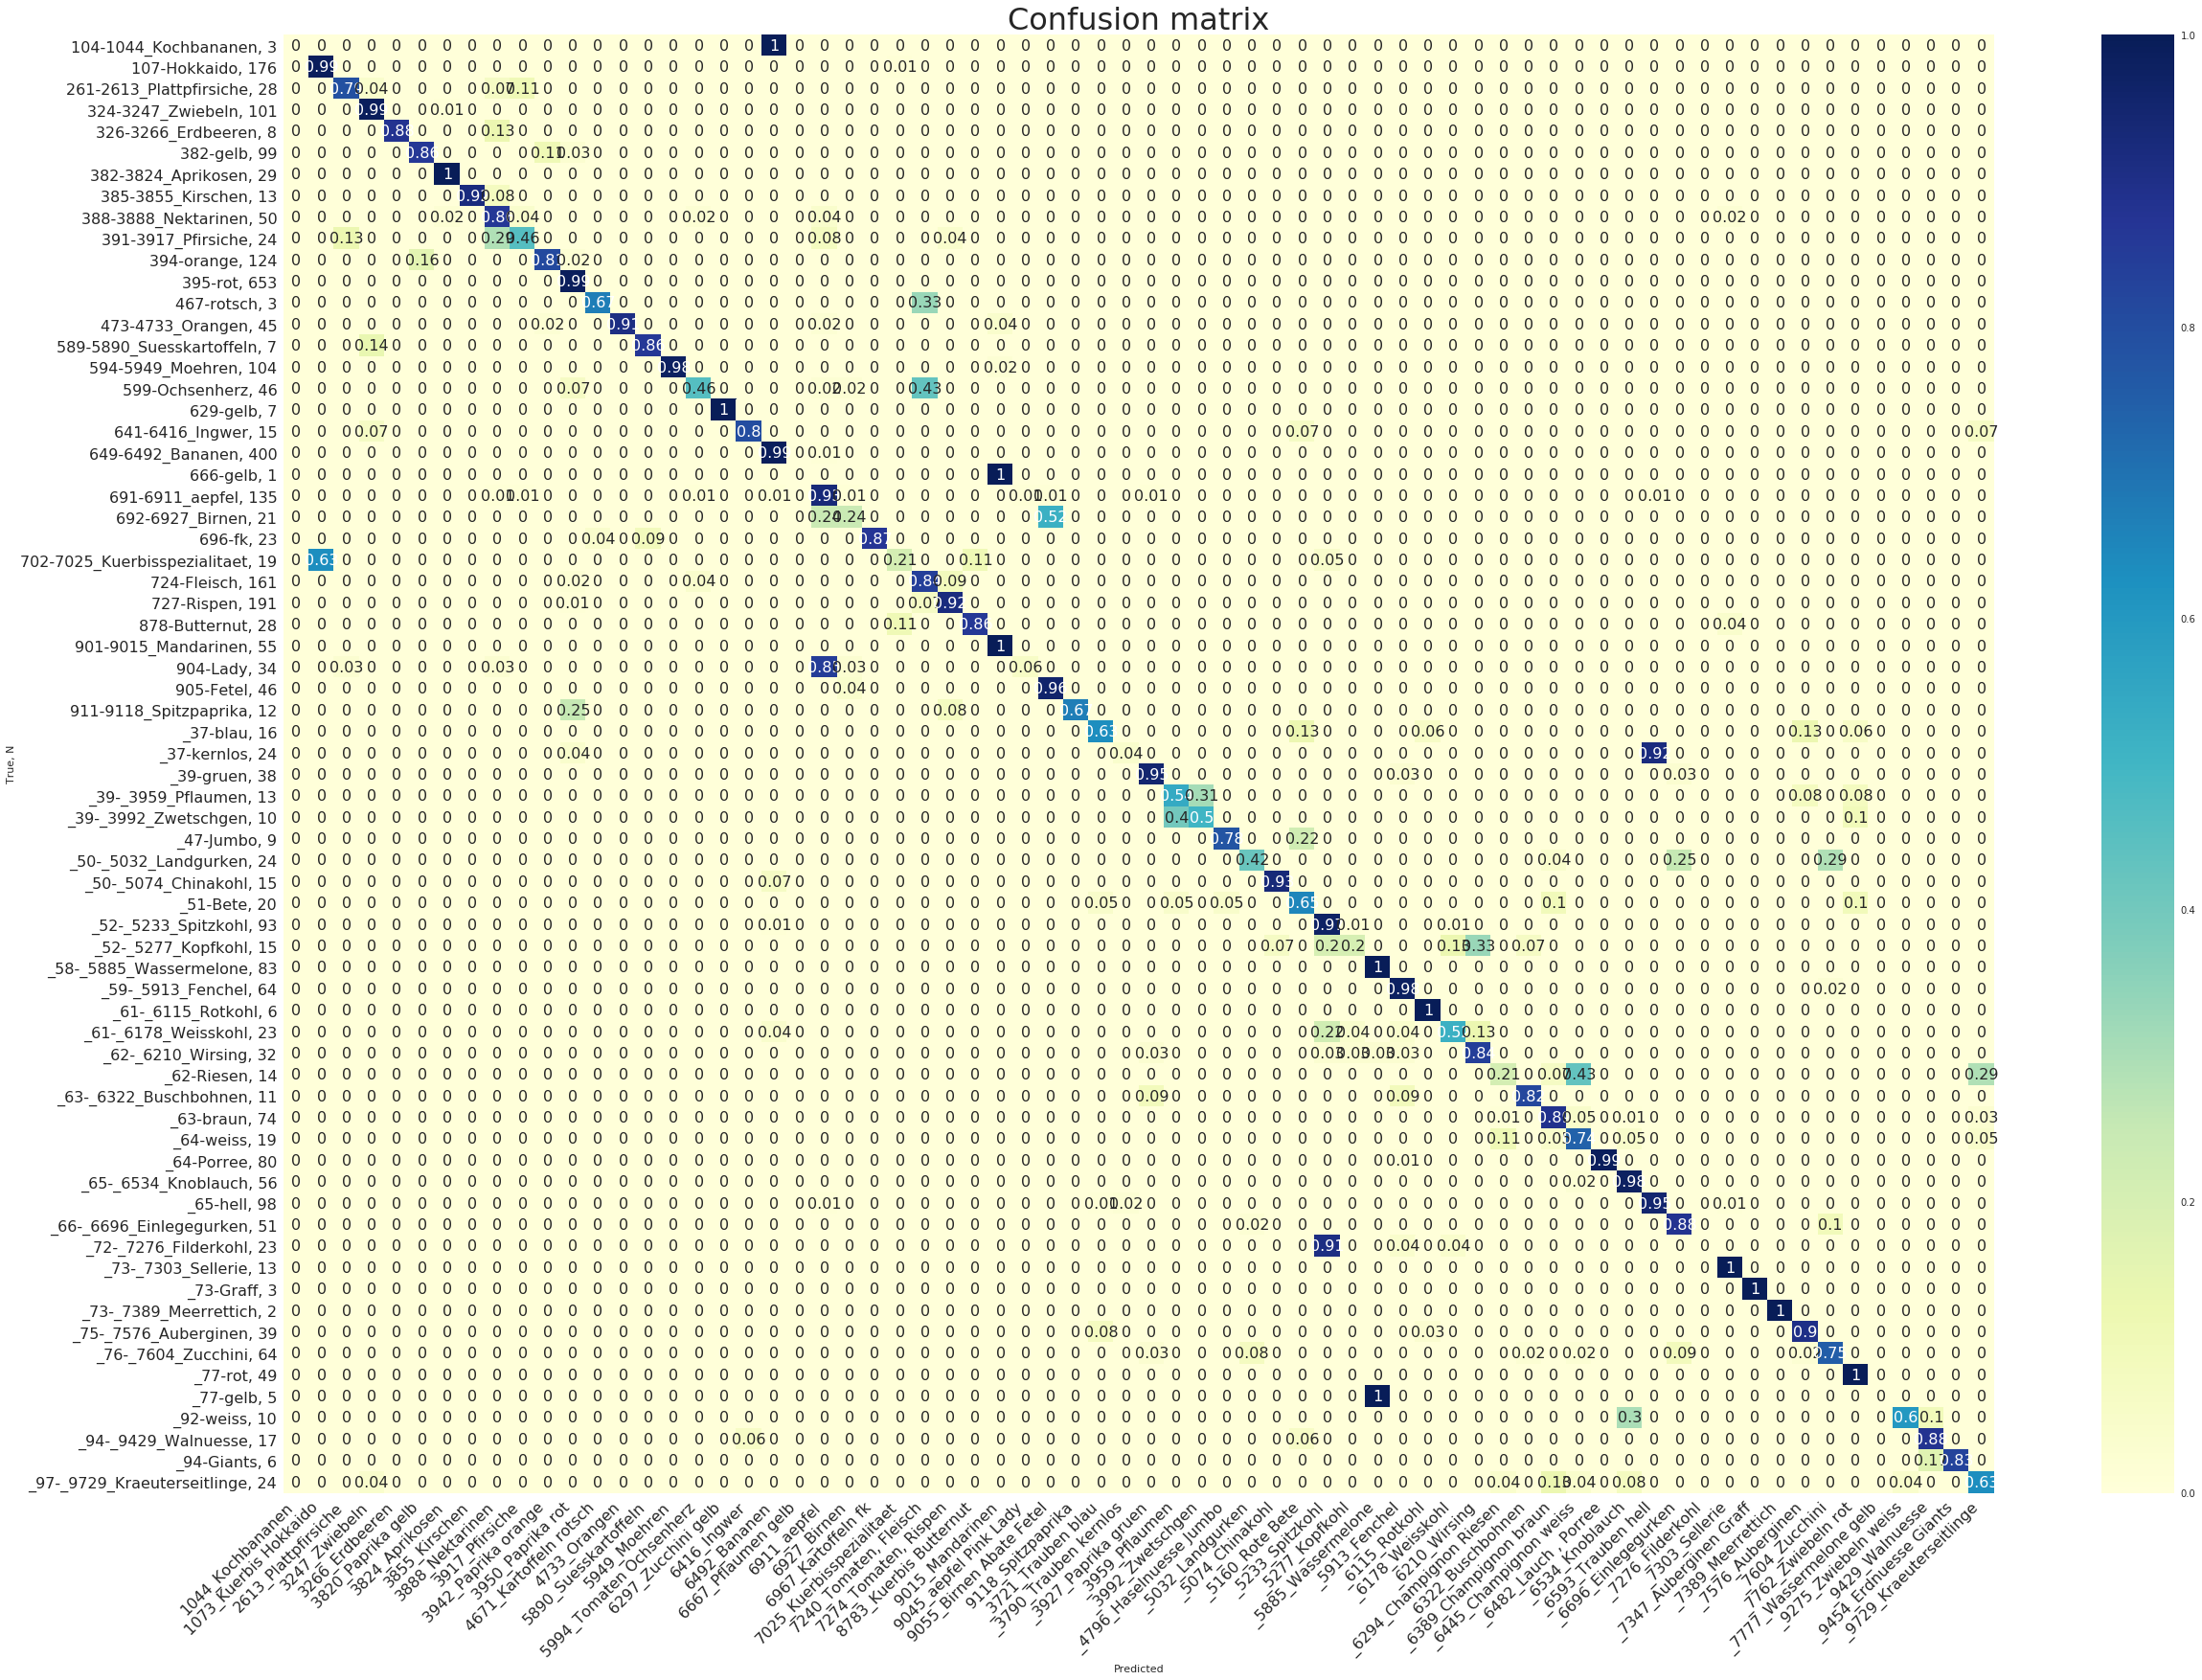

In [233]:
batch_size = 475
cm, cr = report(validation_generator)

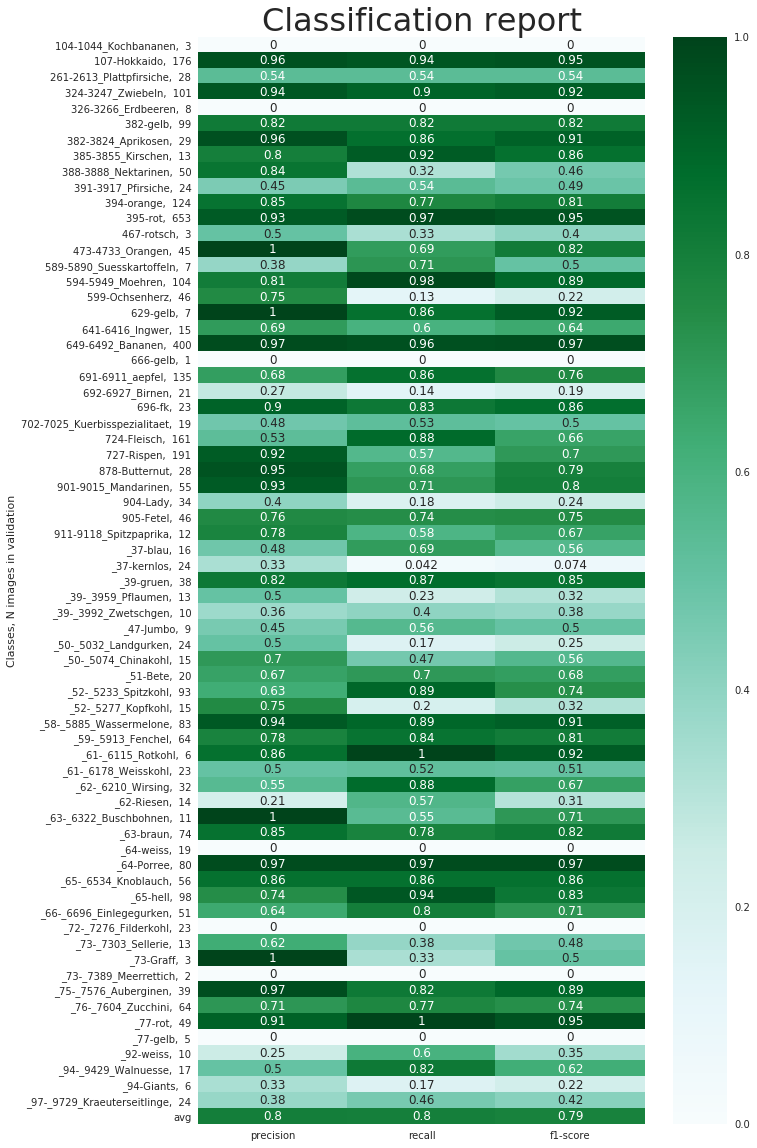

In [165]:
plot_classification_report(Y_true, Y_pred, labels = classes)

In [192]:
def get_model_bn_do0():
    model = Sequential([
#         Lambda(norm_input, input_shape=(img_width, img_height, 3)),
        BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
#         GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(p/4),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(num_classes, activation='softmax')
        ])
    k=3
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy', "top_k_categorical_accuracy"])
    return model
model = get_model_bn_do0()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_126 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_127 (Bat (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 30, 30, 64)        256       
__________

In [254]:
model = get_model_bn_do0()
model.load_weights(home+"models/model.pkl")

In [255]:
batch_size=475

In [256]:
model.evaluate_generator(validation_generator, nb_validation_samples/batch_size)

[0.34097324399913742, 0.90297386500526744, 0.99339141737200831]

In [207]:
model.optimizer.lr=1e-5
model = train_few_epochs(model, 3)

Epoch 1/3
71/71 [==============================] - 214s - loss: 0.3699 - acc: 0.8795 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3984 - val_acc: 0.8738 - val_top_k_categorical_accuracy: 0.9919
Epoch 2/3
71/71 [==============================] - 197s - loss: 0.3602 - acc: 0.8820 - top_k_categorical_accuracy: 0.9951 - val_loss: 0.3963 - val_acc: 0.8732 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/3
71/71 [==============================] - 195s - loss: 0.3640 - acc: 0.8800 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.3972 - val_acc: 0.8726 - val_top_k_categorical_accuracy: 0.9922


In [228]:
model.optimizer.lr=1e-4
model = train_few_epochs(model, 2)

Epoch 1/2
71/71 [==============================] - 215s - loss: 0.3594 - acc: 0.8823 - top_k_categorical_accuracy: 0.9945 - val_loss: 0.3549 - val_acc: 0.8859 - val_top_k_categorical_accuracy: 0.9928
Epoch 2/2
71/71 [==============================] - 197s - loss: 0.3713 - acc: 0.8785 - top_k_categorical_accuracy: 0.9947 - val_loss: 0.3496 - val_acc: 0.8880 - val_top_k_categorical_accuracy: 0.9931


In [242]:
model.save_weights(home+"models/model_d0.pkl")

In [234]:
model.optimizer.lr=1e-5
model = train_few_epochs(model, 3)

Epoch 1/3
71/71 [==============================] - 214s - loss: 0.3600 - acc: 0.8812 - top_k_categorical_accuracy: 0.9947 - val_loss: 0.3355 - val_acc: 0.9009 - val_top_k_categorical_accuracy: 0.9940
Epoch 2/3
71/71 [==============================] - 196s - loss: 0.3607 - acc: 0.8817 - top_k_categorical_accuracy: 0.9949 - val_loss: 0.3367 - val_acc: 0.9012 - val_top_k_categorical_accuracy: 0.9937
Epoch 3/3
71/71 [==============================] - 196s - loss: 0.3628 - acc: 0.8811 - top_k_categorical_accuracy: 0.9947 - val_loss: 0.3380 - val_acc: 0.8988 - val_top_k_categorical_accuracy: 0.9943


In [238]:
model.optimizer.lr=1e-6
model = train_few_epochs(model, 3)

Epoch 1/3
71/71 [==============================] - 212s - loss: 0.3671 - acc: 0.8781 - top_k_categorical_accuracy: 0.9947 - val_loss: 0.3377 - val_acc: 0.9015 - val_top_k_categorical_accuracy: 0.9940
Epoch 2/3
71/71 [==============================] - 198s - loss: 0.3634 - acc: 0.8798 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.3368 - val_acc: 0.9006 - val_top_k_categorical_accuracy: 0.9943
Epoch 3/3
71/71 [==============================] - 195s - loss: 0.3632 - acc: 0.8802 - top_k_categorical_accuracy: 0.9944 - val_loss: 0.3363 - val_acc: 0.9012 - val_top_k_categorical_accuracy: 0.9943


In [240]:
model.optimizer.lr=1e-5
model = train_few_epochs(model, 1)

Epoch 1/1
71/71 [==============================] - 213s - loss: 0.3584 - acc: 0.8811 - top_k_categorical_accuracy: 0.9952 - val_loss: 0.3354 - val_acc: 0.9015 - val_top_k_categorical_accuracy: 0.9940


In [243]:
model.optimizer.lr=1e-4
model = train_few_epochs(model, 2)

Epoch 1/2
71/71 [==============================] - 213s - loss: 0.3619 - acc: 0.8803 - top_k_categorical_accuracy: 0.9947 - val_loss: 0.3364 - val_acc: 0.9012 - val_top_k_categorical_accuracy: 0.9940
Epoch 2/2
71/71 [==============================] - 197s - loss: 0.3598 - acc: 0.8819 - top_k_categorical_accuracy: 0.9943 - val_loss: 0.3356 - val_acc: 0.9021 - val_top_k_categorical_accuracy: 0.9937


In [244]:
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [248]:
fpath = home+"models/model-1.pkl"
ModelCheckpoint(fpath, monitor='val_loss', verbose=0, save_best_only=True)
EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
callbacks = [ModelCheckpoint(fpath, monitor='val_loss', verbose=0, save_best_only=True),
            EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

In [249]:
def train_few_epochs_(model, num_epochs, verbose=1):
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
    return model


In [250]:
p=0.75
model = get_model_bn_do()
model = train_few_epochs_(model, 200)

Epoch 1/200
71/71 [==============================] - 214s - loss: 2.8766 - acc: 0.4060 - top_k_categorical_accuracy: 0.6871 - val_loss: 5.1540 - val_acc: 0.0297 - val_top_k_categorical_accuracy: 0.1018
Epoch 2/200
71/71 [==============================] - 195s - loss: 1.7431 - acc: 0.5483 - top_k_categorical_accuracy: 0.8542 - val_loss: 5.9287 - val_acc: 0.0433 - val_top_k_categorical_accuracy: 0.0700
Epoch 3/200
71/71 [==============================] - 195s - loss: 1.4202 - acc: 0.6034 - top_k_categorical_accuracy: 0.9003 - val_loss: 5.3634 - val_acc: 0.0778 - val_top_k_categorical_accuracy: 0.1733
Epoch 4/200
71/71 [==============================] - 195s - loss: 1.2382 - acc: 0.6438 - top_k_categorical_accuracy: 0.9226 - val_loss: 5.3841 - val_acc: 0.0583 - val_top_k_categorical_accuracy: 0.1664
Epoch 5/200
71/71 [==============================] - 196s - loss: 1.1108 - acc: 0.6711 - top_k_categorical_accuracy: 0.9388 - val_loss: 3.4758 - val_acc: 0.1502 - val_top_k_categorical_accurac

71/71 [==============================] - 194s - loss: 0.4129 - acc: 0.8629 - top_k_categorical_accuracy: 0.9936 - val_loss: 0.4017 - val_acc: 0.8810 - val_top_k_categorical_accuracy: 0.9916
Epoch 42/200
71/71 [==============================] - 194s - loss: 0.4132 - acc: 0.8645 - top_k_categorical_accuracy: 0.9929 - val_loss: 0.3985 - val_acc: 0.8792 - val_top_k_categorical_accuracy: 0.9931
Epoch 43/200
71/71 [==============================] - 194s - loss: 0.4037 - acc: 0.8684 - top_k_categorical_accuracy: 0.9932 - val_loss: 0.3906 - val_acc: 0.8880 - val_top_k_categorical_accuracy: 0.9919
Epoch 44/200
71/71 [==============================] - 194s - loss: 0.4048 - acc: 0.8675 - top_k_categorical_accuracy: 0.9936 - val_loss: 0.3941 - val_acc: 0.8825 - val_top_k_categorical_accuracy: 0.9928
Epoch 45/200
71/71 [==============================] - 194s - loss: 0.4063 - acc: 0.8655 - top_k_categorical_accuracy: 0.9925 - val_loss: 0.3975 - val_acc: 0.8819 - val_top_k_categorical_accuracy: 0.990

In [290]:
def get_model_bn_do0():
    model = Sequential([
#         Lambda(norm_input, input_shape=(img_width, img_height, 3)),
        BatchNormalization(axis=-1, input_shape=(img_width, img_height, 3)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=-1),
        Conv2D(128,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
#         GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(p/4),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(num_classes, activation='softmax')
        ])
    k=3
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy', "top_k_categorical_accuracy"])
    return model
model = get_model_bn_do0()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_276 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_277 (Bat (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_278 (Bat (None, 30, 30, 64)        256       
__________

In [269]:
model = get_model_bn_do0()
model.load_weights(home+"models/model.pkl")

In [270]:
model.optimizer.lr=1e-5
model = train_few_epochs(model, 30)

Epoch 1/30
71/71 [==============================] - 214s - loss: 0.2850 - acc: 0.9046 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.3351 - val_acc: 0.9039 - val_top_k_categorical_accuracy: 0.9940
Epoch 2/30
71/71 [==============================] - 197s - loss: 0.2858 - acc: 0.9034 - top_k_categorical_accuracy: 0.9975 - val_loss: 0.3376 - val_acc: 0.9021 - val_top_k_categorical_accuracy: 0.9940
Epoch 3/30
71/71 [==============================] - 195s - loss: 0.2842 - acc: 0.9053 - top_k_categorical_accuracy: 0.9972 - val_loss: 0.3363 - val_acc: 0.9033 - val_top_k_categorical_accuracy: 0.9937
Epoch 4/30
71/71 [==============================] - 202s - loss: 0.2821 - acc: 0.9046 - top_k_categorical_accuracy: 0.9973 - val_loss: 0.3343 - val_acc: 0.9030 - val_top_k_categorical_accuracy: 0.9937
Epoch 5/30
71/71 [==============================] - 204s - loss: 0.2788 - acc: 0.9068 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.3376 - val_acc: 0.9024 - val_top_k_categorical_accuracy: 0.

KeyboardInterrupt: 

In [289]:
p=0

# validation set

In [264]:
print  "model with BatchNorm+Dropout 0.8"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model.pkl")
model.evaluate_generator(validation_generator, nb_validation_samples/batch_size)

model with BatchNorm+Dropout 0.8

      val loss             top1 score             top3 score      



[0.34097324399913742, 0.90297386500526744, 0.99339141737200831]

In [265]:
print  "model tuned with a few more epochs where Dropout is set to 0"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model_d0.pkl")
model.evaluate_generator(validation_generator, nb_validation_samples/batch_size)

model tuned with a few more epochs where Dropout is set to 0

      val loss             top1 score             top3 score      



[0.33503147153551421, 0.90177229756741739, 0.99459298094244963]

In [268]:
print  "model with BatchNorm+Dropout 0.8 and Scheduled to decrease after 10 epochs without progress"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model-sheduled.pkl")
model.evaluate_generator(validation_generator, nb_validation_samples/batch_size)

model with BatchNorm+Dropout 0.8 and Scheduled to decrease after 10 epochs without progress

      val loss             top1 score             top3 score      



[0.38221502454028755, 0.88825473329905602, 0.99158907201634616]

# test set

In [280]:
test_dir  = home + 'data/test/'
nb_test_samples = 16248
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False
        )

Found 16248 images belonging to 68 classes.


In [291]:
print  "model with BatchNorm+Dropout 0.8"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model.pkl")
model.evaluate_generator(test_generator, nb_test_samples/batch_size)

model with BatchNorm+Dropout 0.8

      val loss             top1 score             top3 score      



KeyboardInterrupt: 

In [292]:
print  "model tuned with a few more epochs where Dropout is set to 0"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model_d0.pkl")
model.evaluate_generator(test_generator, nb_test_samples/batch_size)

model tuned with a few more epochs where Dropout is set to 0

      val loss             top1 score             top3 score      



[0.34772974170403376, 0.88765612251974879, 0.99454764669701667]

In [ ]:
print  "model with BatchNorm+Dropout 0.8 and Scheduled to decrease after 10 epochs without progress"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model-sheduled.pkl")
model.evaluate_generator(test_generator, nb_test_samples/batch_size)

In [ ]:
plot_classification_report(test_generator)

In [293]:
report(test_generator)

ValueError: Found input variables with inconsistent numbers of samples: [16248, 3898]

# whole dataset

In [281]:
whole_dir  = home + 'data/whole/'
nb_whole_samples = 37795
whole_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,    
        rotation_range=10,
        horizontal_flip=True,
)
whole_generator = whole_datagen.flow_from_directory(
        whole_dir,  
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        )

Found 37795 images belonging to 68 classes.


In [285]:
def train_few_epochs_all(model, num_epochs, verbose=1):
    model.fit_generator(
        whole_generator,
        steps_per_epoch=nb_whole_samples // batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose,
        validation_data=test_generator,
        validation_steps=nb_test_samples // batch_size)
    return model

In [286]:
p=0.4
model = get_model_bn_do0()
model.load_weights(home+"models/model_d0.pkl")

In [287]:
model.optimizer.lr=1e-5
model = train_few_epochs(model, 5)

Epoch 1/5
71/71 [==============================] - 229s - loss: 0.2974 - acc: 0.9015 - top_k_categorical_accuracy: 0.9968 - val_loss: 0.3371 - val_acc: 0.9012 - val_top_k_categorical_accuracy: 0.9943
Epoch 2/5
71/71 [==============================] - 196s - loss: 0.2957 - acc: 0.9014 - top_k_categorical_accuracy: 0.9966 - val_loss: 0.3346 - val_acc: 0.9018 - val_top_k_categorical_accuracy: 0.9943
Epoch 3/5
71/71 [==============================] - 199s - loss: 0.2965 - acc: 0.9017 - top_k_categorical_accuracy: 0.9969 - val_loss: 0.3344 - val_acc: 0.9036 - val_top_k_categorical_accuracy: 0.9943
Epoch 4/5
71/71 [==============================] - 199s - loss: 0.3007 - acc: 0.9002 - top_k_categorical_accuracy: 0.9969 - val_loss: 0.3355 - val_acc: 0.9021 - val_top_k_categorical_accuracy: 0.9934
Epoch 5/5
71/71 [==============================] - 201s - loss: 0.2947 - acc: 0.9015 - top_k_categorical_accuracy: 0.9970 - val_loss: 0.3332 - val_acc: 0.9039 - val_top_k_categorical_accuracy: 0.9940


In [ ]:
model.optimizer.lr=1e-6
model = train_few_epochs(model, 5)

In [ ]:
print  "model tuned with train + validation"
print
print "      val loss      ", "      top1 score      ", "      top3 score      "
print
model = get_model_bn_do0()
model.load_weights(home+"models/model_1.pkl")
model.evaluate_generator(validation_generator, nb_validation_samples/batch_size)

In [295]:
def plot_classification_report_test(generator,labels=False, figsize=(10, 20), ax=None):
    
    Y_true = get_labels(generator)
    Y_pred = model.predict_generator(generator, nb_test_samples/batch_size+1)
    
    Y_true = np.argmax(Y_true, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)
    
    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score']

    cr = precision_recall_fscore_support(Y_true, Y_pred)
    a =  cr[-1]
    yticks = [labels[i][:3]+"-"+labels[i].split()[-1]+",  "+str(a[i]) for i in range(len(labels))]
    yticks += ['avg']
    
    rep = np.array(cr).T
    avg = precision_recall_fscore_support(Y_true, Y_pred, average = "weighted")
#     avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sn.heatmap(rep[:,:-1],
                annot=True, 
                cmap="BuGn", 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)
    
    plt.title('Classification report', fontsize=32)

    plt.ylabel('Classes, N images in validation')
#     plt.savefig("./class_rep.eps")
    plt.savefig("./class_rep_test.svg")
    return Y_true, Y_pred

def plot_conf_mat_test(Y_true, Y_pred, labels=True):
    if not labels:
        labels = np.unique(Y_true, return_counts=True)[0]
    array = confusion_matrix(Y_true, Y_pred)
    C = array / array.astype(np.float).sum(axis=1)[:, np.newaxis]
    a = [] 
    for i in C:
        a.append([round(e,2) for e in i])

    df_cm = pd.DataFrame(a)
    plt.figure(figsize = (40,28))
    df_cm = pd.DataFrame(a, range(len(labels)),
                      range(len(labels)))
    #plt.figure(figsize = (10,7))
    a = np.unique(Y_true, return_counts=True)[1]
    ylabels = [labels[i][:3]+"-"+labels[i].split()[-1]+", "+str(a[i]) for i in range(len(labels))]
    sn.set(font_scale=1.)#for label size
    sn.heatmap(df_cm,  annot=True, annot_kws={"size": 16}, linewidth=0,xticklabels=labels, yticklabels=ylabels, cmap="YlGnBu")
    plt.title('Confusion matrix - Top1 suggestion', fontsize=32)
    plt.yticks(rotation=0, ha="right", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=16)
#     plt.set_xticklabels( )
    plt.ylabel('True, N')
    plt.xlabel('Predicted')
#     plt.savefig("./conf.eps")
    plt.savefig("./conf_test.svg")

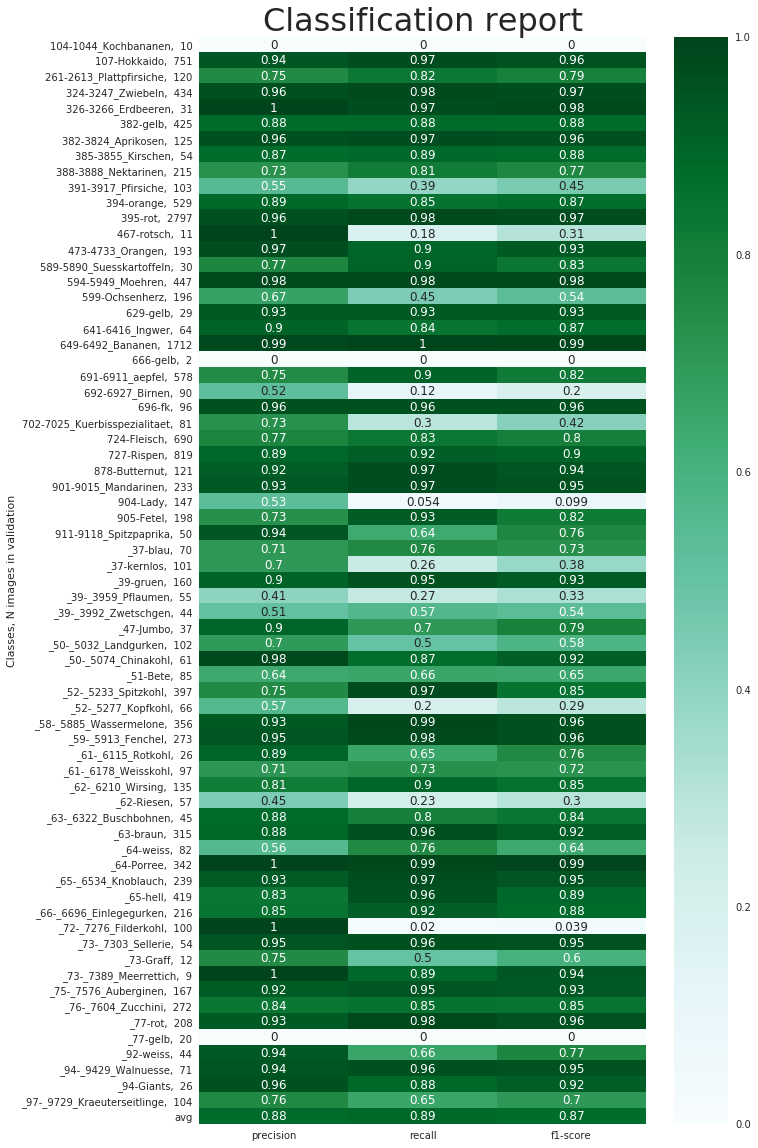

In [297]:
Y_true, Y_pred = plot_classification_report_test(test_generator, labels=classes)

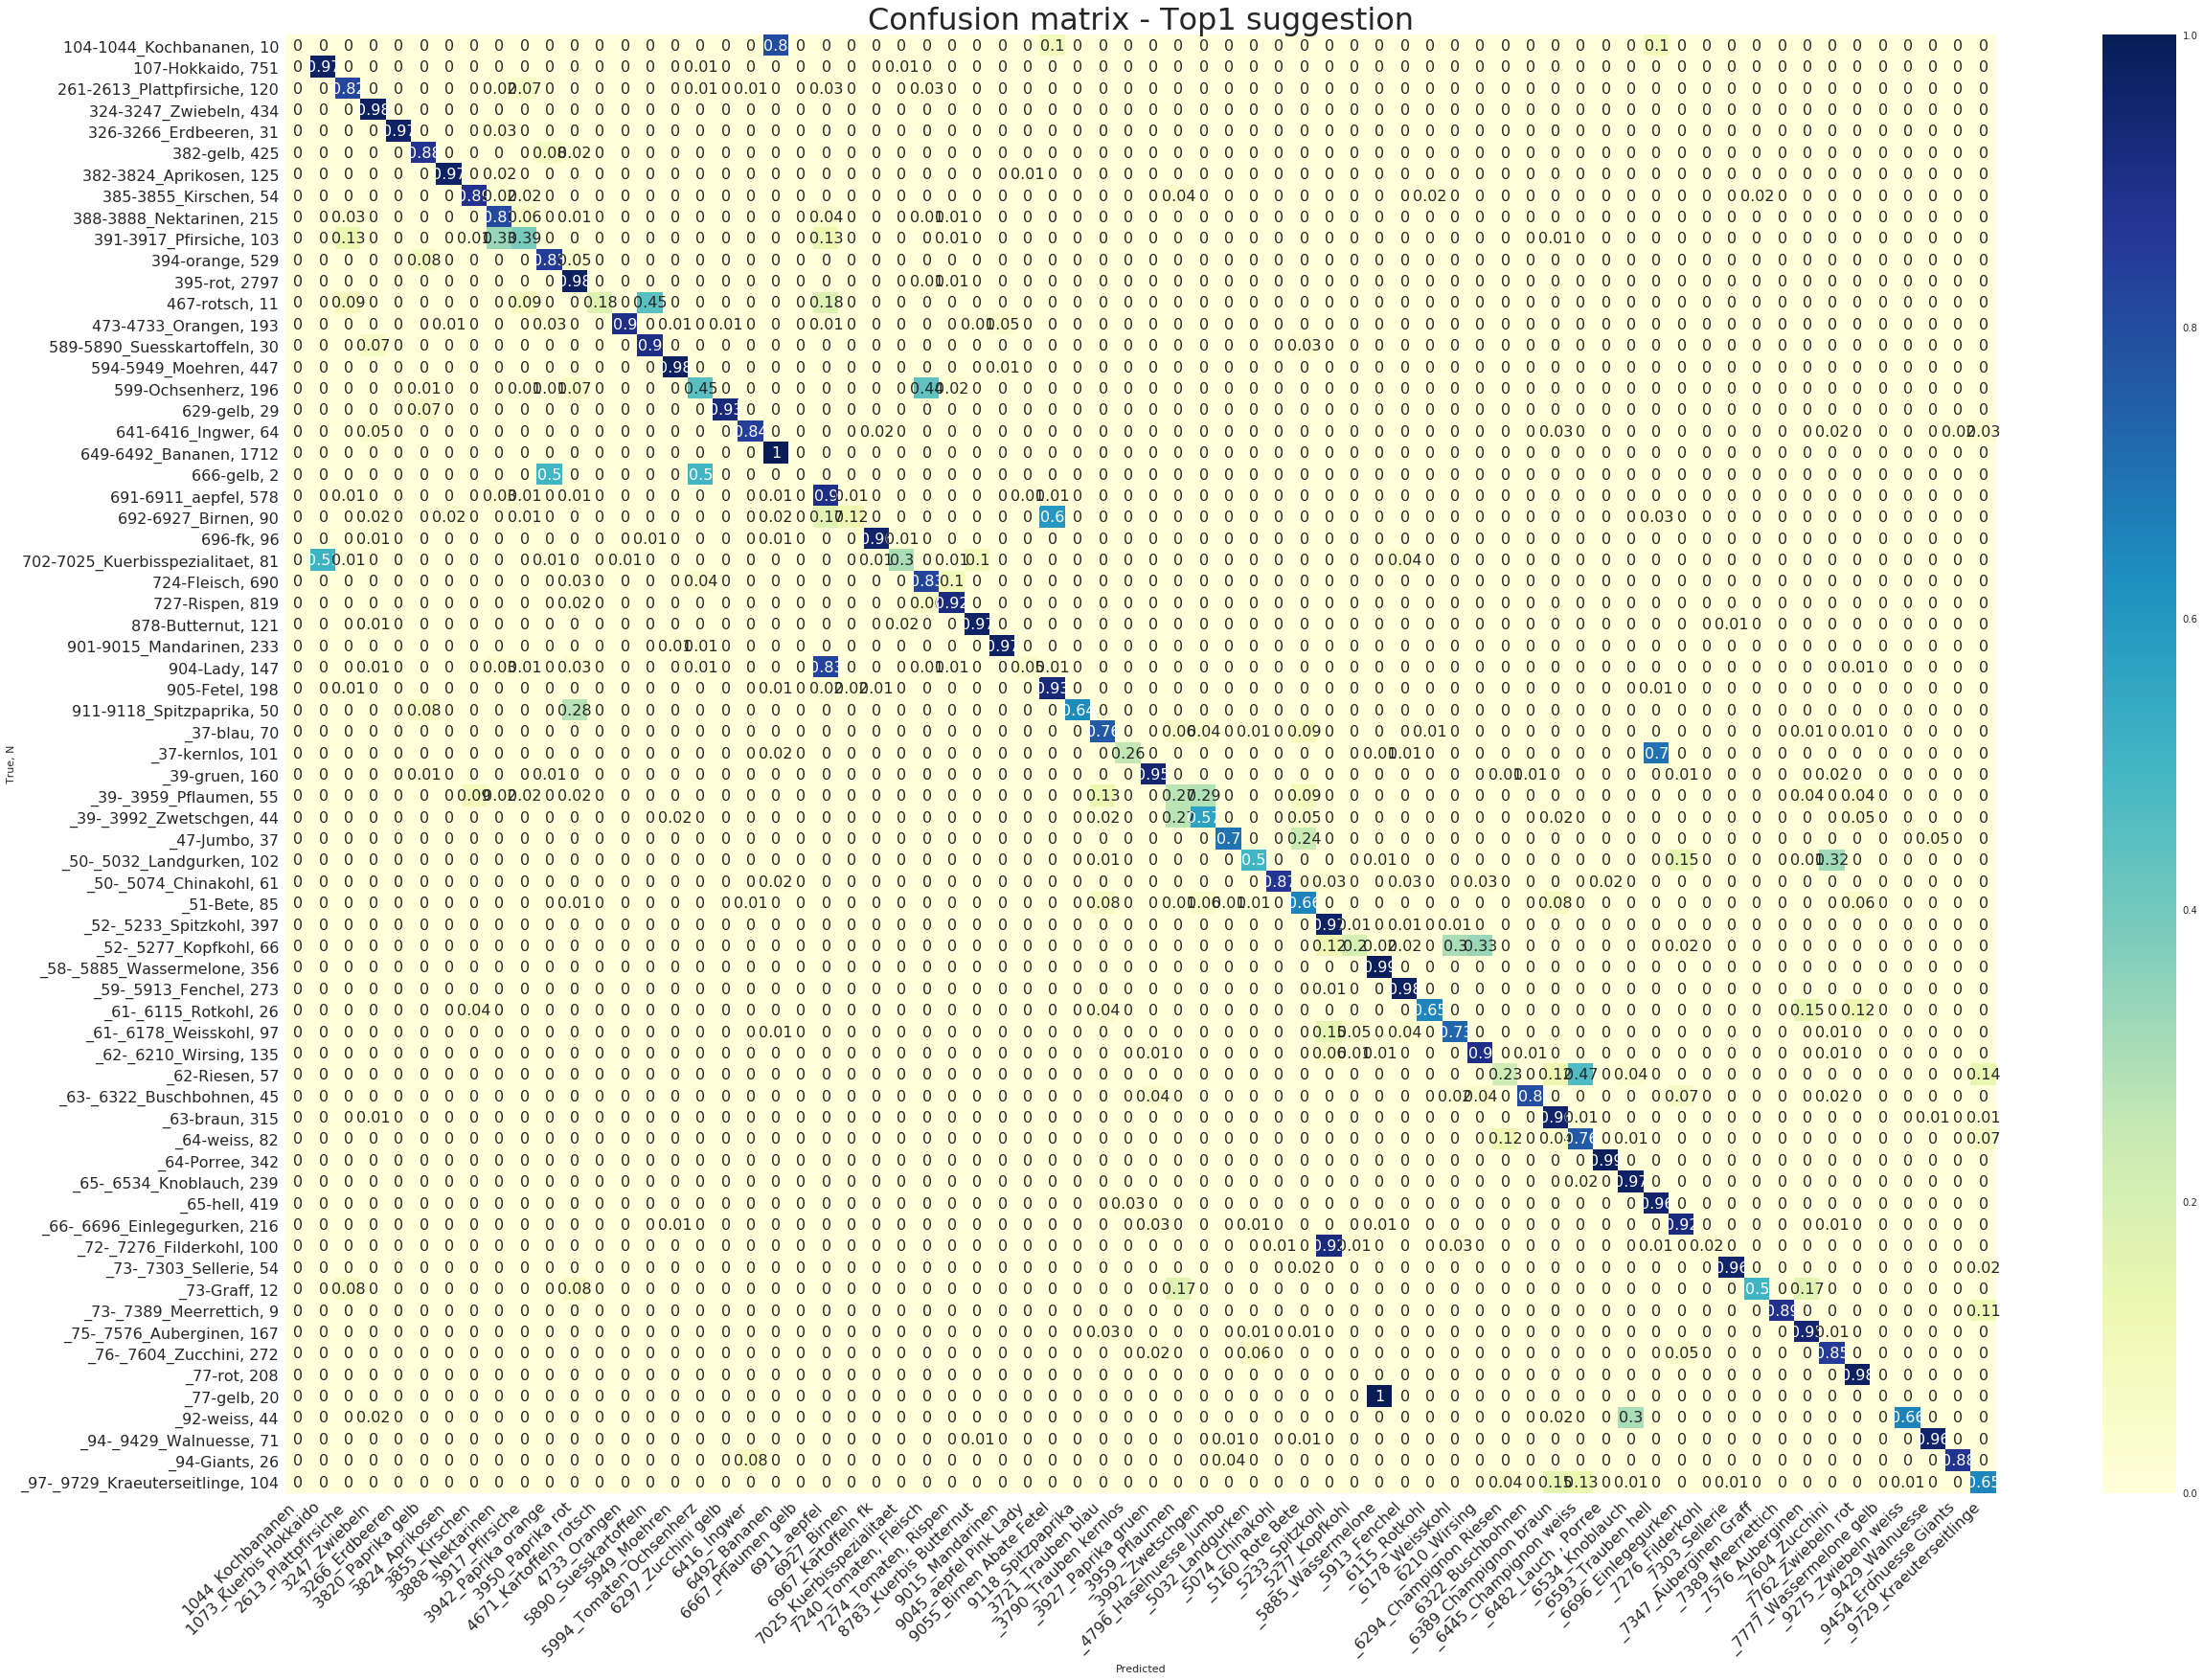

In [298]:
plot_conf_mat_test(Y_true, Y_pred, labels=classes)